## Learning LangGraph 

In [17]:
import langchain
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain_google_genai import GoogleGenerativeAIEmbeddings

from langgraph.graph import StateGraph, START, END

from dotenv import load_dotenv
from pprint import pprint
import random
from loguru import logger
from typing import TypedDict, Annotated
from IPython.display import Image

In [4]:
gemini_flash_model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [5]:
gpt_oss_20b_model = ChatGroq(
    model="openai/gpt-oss-20b",
    temperature=0,
    max_tokens=None,
    reasoning_format="parsed",
    timeout=None,
    max_retries=2,
)

In [6]:
gemini_flash_model.invoke("what is the capital of india").content

'The capital of India is **New Delhi**.'

In [7]:
gpt_oss_20b_model.invoke("what is the capital of india").content

'The capital of India is **New\u202fDelhi**.'

### First Sequential Workflow - non LLM based

- BMI Calculator

- Inputs: ht, weight

- Output: BMI

In [21]:
# define state

class BMIState(TypedDict):
    weight_kg: float
    height_m: float
    bmi: float
    category: str

In [23]:
# define graph

bmi_graph = StateGraph(BMIState)

# define nodes - nodes are functions that take in a state and return a state

def calculate_bmi(state: BMIState) -> BMIState:
    bmi = state["weight_kg"] / (state["height_m"] ** 2)
    state["bmi"] = round(bmi, 2) # make a partial update to the state
    return state

def label_bmi(state: BMIState) -> BMIState:
    if state["bmi"] < 18.5:
        state["category"] = "Underweight"
    elif 18.5 <= state["bmi"] < 25:
        state["category"] = "Normal weight"
    elif 25 <= state["bmi"] < 30:
        state["category"] = "Overweight"
    else:
        state["category"] = "Obese"
    
    return state

bmi_graph.add_node("calculate_bmi", calculate_bmi)
bmi_graph.add_node("label_bmi", label_bmi)
 
# add edges
bmi_graph.add_edge(START, "calculate_bmi") # START and END are special dummy nodes
bmi_graph.add_edge("calculate_bmi", "label_bmi")
bmi_graph.add_edge("label_bmi", END)

# compile graph
workflow = bmi_graph.compile()

In [25]:
# invoke graph
initial_state = {"weight_kg": 99, "height_m": 1.75}
final_state = workflow.invoke(initial_state)
pprint(final_state)

{'bmi': 32.33, 'category': 'Obese', 'height_m': 1.75, 'weight_kg': 99}


Note that the input of the graph is a state and the output of the graph is also a state

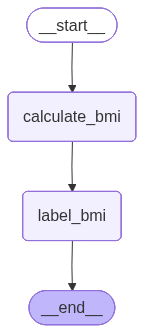

In [26]:
Image(workflow.get_graph().draw_mermaid_png())

### First Sequential Workflow - LLM based

- Simple QA workflow

In [27]:
class LLMState(TypedDict):
    question: str
    answer: str

In [28]:
# define graph

qa_graph = StateGraph(LLMState)

# define nodes - nodes are functions that take in a state and return a state
def llm_qa(state: LLMState) -> LLMState:

    question = state["question"]
    # build prompt 
    template = PromptTemplate(
        template="""
        You are a helpful assistant.
        Answer the following question: {question}
        """,
        input_variables=["question"]
    )

    prompt = template.format(question=question)
    answer = gpt_oss_20b_model.invoke(prompt).content
    
    state["answer"] = answer
    return state

qa_graph.add_node("llm_qa", llm_qa)
 
# add edges
qa_graph.add_edge(START, "llm_qa") # START and END are special dummy nodes
qa_graph.add_edge("llm_qa", END)

# compile graph
workflow = qa_graph.compile()

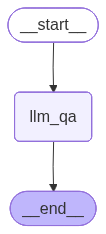

In [29]:
Image(workflow.get_graph().draw_mermaid_png())

In [30]:
initial_state = {"question": "What is the capital of India?"}
final_state = workflow.invoke(initial_state)
pprint(final_state)

{'answer': 'The capital of India is **New Delhi**.',
 'question': 'What is the capital of India?'}


### Prompt Chaining Workflow

In [33]:
class BlogState(TypedDict):
    title: str
    outline: str
    content: str

def create_outline(state: BlogState) -> BlogState:
    
    title = state["title"]
    # build prompt 
    template = PromptTemplate(
        template="""
        You are a helpful assistant.
        Create an outline for the following blog post: {title}
        """,
        input_variables=["title"]
    )
    prompt = template.format(title=title)
    outline = gpt_oss_20b_model.invoke(prompt).content
    state["outline"] = outline
    return state

def create_blog(state: BlogState) -> BlogState:
    
    title = state["title"]
    outline = state["outline"]
    # build prompt 
    template = PromptTemplate(
        template="""
        You are a helpful assistant.
        Create a short blog post for the following title: {title} and using the following outline:\n {outline}
        """,
        input_variables=["title", "outline"]
    )
    prompt = template.format(title=title, outline=outline)
    content = gpt_oss_20b_model.invoke(prompt).content
    state["content"] = content
    return state

# define graph
blog_graph = StateGraph(BlogState)

# define nodes - nodes are functions that take in a state and return a state
blog_graph.add_node("create_outline", create_outline)
blog_graph.add_node("create_blog", create_blog)

# add edges
blog_graph.add_edge(START, "create_outline")
blog_graph.add_edge("create_outline", "create_blog")
blog_graph.add_edge("create_blog", END)

# compile graph
workflow = blog_graph.compile()


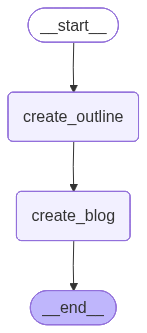

In [34]:
Image(workflow.get_graph().draw_mermaid_png())

In [36]:
initial_state = {"title": "LangGraph Tutorial"}
final_state = workflow.invoke(initial_state)

In [40]:
final_state.keys()

dict_keys(['title', 'outline', 'content'])

In [39]:
print(final_state["content"][:1000])

# LangGraph Tutorial  
*A quick‑start guide to building conversational AI workflows with LangGraph*

---

## 1. Introduction  

### What is LangGraph?  
LangGraph is a lightweight framework that lets you stitch together LLM calls, data‑transformations, and external APIs into a **graph‑based workflow**. Think of it as a visual, modular way to build chatbots, assistants, or any conversational system that needs to keep track of state, branch logic, and side‑effects.

Why it matters  
* **Modularity** – each node is a self‑contained unit.  
* **Scalability** – graphs can grow from a single LLM call to dozens of nodes.  
* **LLM agnostic** – plug in OpenAI, Anthropic, or any other provider with a single line.

### Target audience  
Developers, data scientists, and AI enthusiasts who want to prototype or deploy chatbots without wrestling with low‑level orchestration.

### What you’ll learn  
* Core concepts (nodes, edges, state, callbacks).  
* How to install and set up a project.  
* Buildi